In [9]:
# Loading the data
import pandas as pd
import numpy as np
from scipy.stats import zscore

df = pd.read_csv("./data/sierraleone-bumbuna.csv")

In [10]:
# Summary Statistics & Missing-Value Report
df.describe()

,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,201.957515,116.376337,113.720571,206.643095,198.114691,26.319394,79.448857,1.146113,1.691606,0.363823,133.044668,7.172220,999.876469,0.000967,0.004806,32.504263,32.593091,NaN
std,298.495150,218.652659,158.946032,300.896893,288.889073,4.398605,20.520775,1.239248,1.617053,0.295000,114.284792,7.535093,2.104419,0.031074,0.047556,12.434899,12.009161,NaN
min,-19.500000,-7.800000,-17.900000,0.000000,0.000000,12.300000,9.900000,0.000000,0.000000,0.000000,0.000000,0.000000,993.000000,0.000000,0.000000,10.700000,11.100000,NaN
25%,-2.800000,-0.300000,-3.800000,0.000000,0.000000,23.100000,68.700000,0.000000,0.000000,0.000000,0.000000,0.000000,999.000000,0.000000,0.000000,23.500000,23.800000,NaN
50%,0.300000,-0.100000,-0.100000,3.600000,3.400000,25.300000,85.400000,0.800000,1.600000,0.400000,161.500000,6.200000,1000.000000,0.000000,0.000000,26.600000,26.900000,NaN
75%,362.400000,107.000000,224.700000,359.500000,345.400000,29.400000,96.700000,2.000000,2.600000,0.600000,234.100000,12.000000,1001.000000,0.000000,0.000000,40.900000,41.300000,NaN
max,1499.000000,946.000000,892.000000,1507.000000,1473.000000,39.900000,100.000000,19.200000,23.900000,4.100000,360.000000,98.400000,1006.000000,1.000000,2.400000,72.800000,70.400000,NaN


In [11]:
# Number of null items for each cols
null_items = df.isna().sum()

In [12]:
# Check if it has more than 5% null data
threshold = len(df) * 0.05
answer = null_items[null_items > threshold]
print(answer)

Comments    525600
dtype: int64


In [13]:
cols = ['GHI','DNI','DHI','ModA','ModB','WS','WSgust']
zs = df[cols].apply(lambda x: zscore(x)) 
zs = zs.abs()

df['is_outlier'] = (zs > 3).any(axis=1)

# 4. Null outliers and impute
df_clean = df.copy()
df_clean.loc[df_clean['is_outlier'], cols] = np.nan

for c in cols:
    median = df_clean[c].median()
    df_clean[c].fillna(median, inplace=True)

df_clean.to_csv("data/sierraleone_clean.csv")

C:\Users\hp\AppData\Local\Temp\ipykernel_6256\1265646540.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[c].fillna(median, inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_6256\1265646540.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

c:\Users\hp\Desktop\solar-challenge-week1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


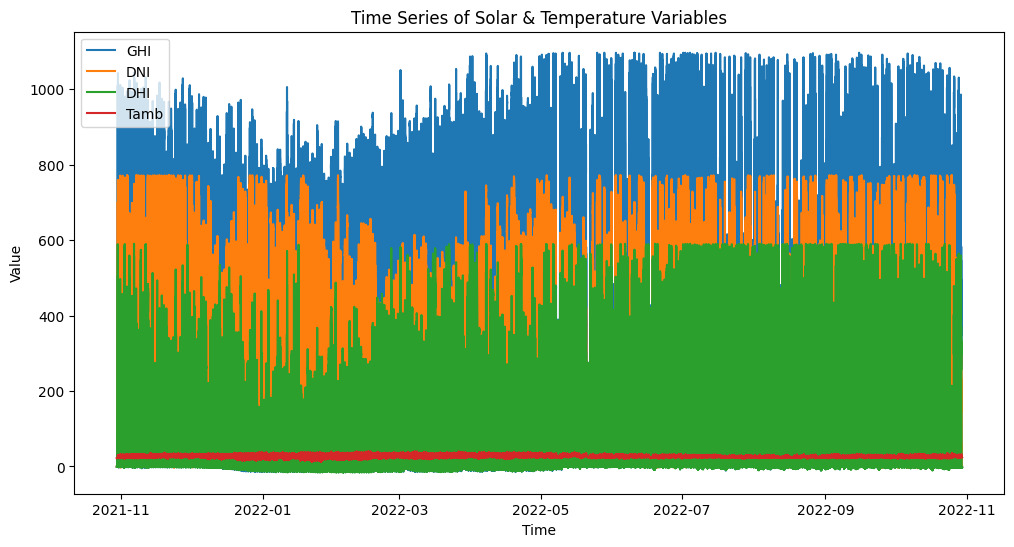

In [14]:
import matplotlib.pyplot as plt

df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])
df_clean.set_index('Timestamp', inplace=True)

plt.figure(figsize=(12,6))
for var in ['GHI','DNI','DHI','Tamb']:
    plt.plot(df_clean.index, df_clean[var], label=var)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time Series of Solar & Temperature Variables")
plt.legend()
plt.show()

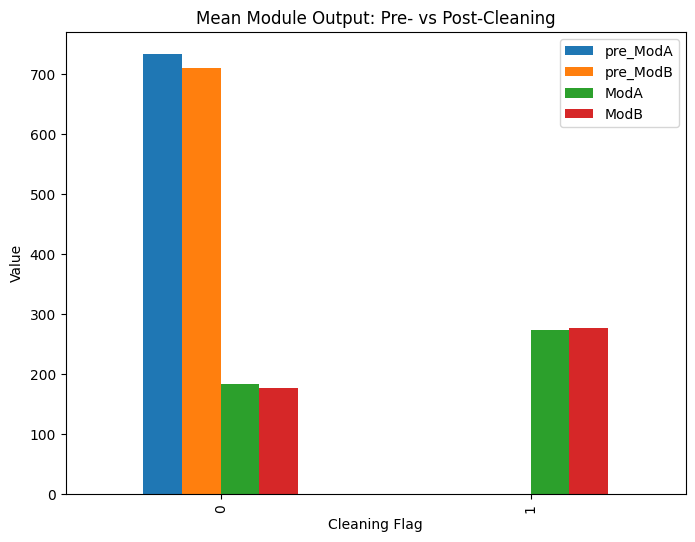

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create “pre” values only where outliers were flagged
df_clean['pre_ModA'] = np.where(df['is_outlier'], df['ModA'], np.nan)
df_clean['pre_ModB'] = np.where(df['is_outlier'], df['ModB'], np.nan)

# Group by your Cleaning flag
impact = df_clean.groupby('Cleaning')[['pre_ModA','pre_ModB','ModA','ModB']].mean()

# Plot
impact.plot(kind='bar', figsize=(8,6))
plt.title("Mean Module Output: Pre- vs Post-Cleaning")
plt.xlabel("Cleaning Flag")
plt.ylabel("Value")
plt.show()


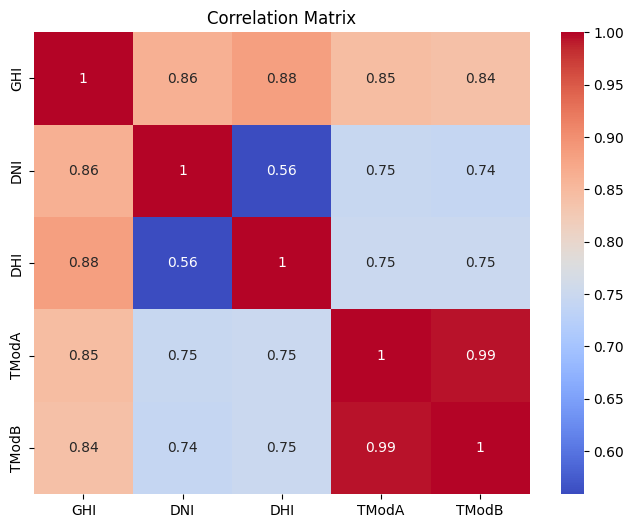

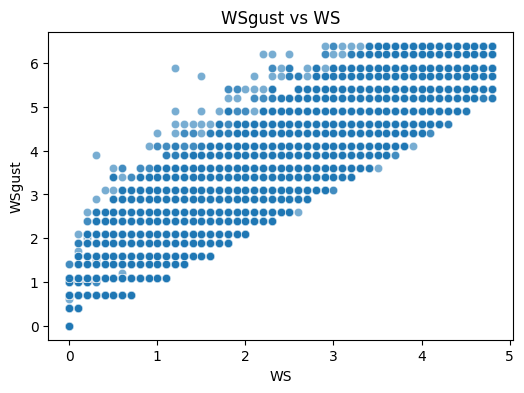

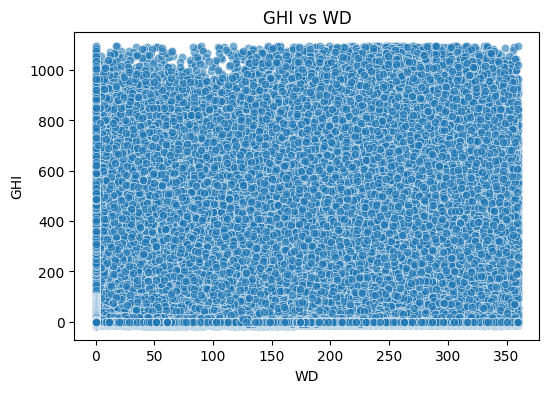

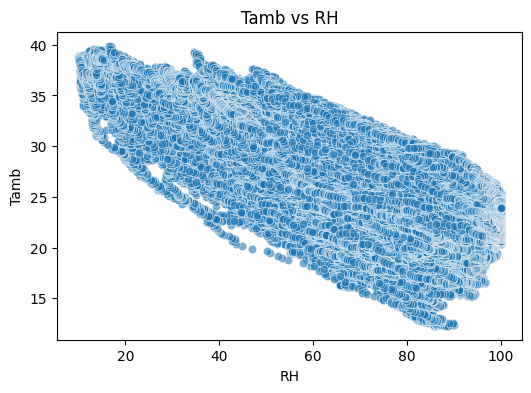

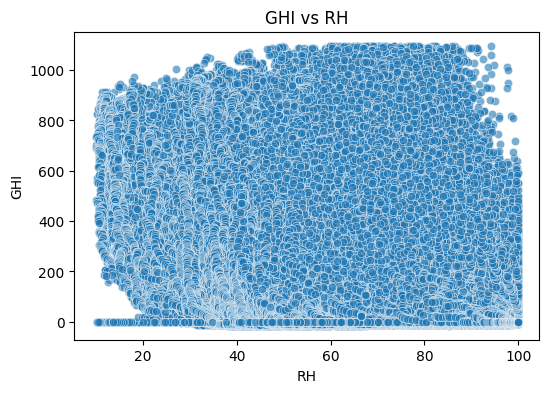

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# 4a. Heatmap of correlations
vars_corr = ['GHI','DNI','DHI','TModA','TModB']
corr = df_clean[vars_corr].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# 4b. Scatter‐plot pairs
pairs = [('WS','WSgust'), ('WD','GHI'), ('RH','Tamb'), ('RH','GHI')]
for x,y in pairs:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df_clean, x=x, y=y, alpha=0.6)
    plt.title(f"{y} vs {x}")
    plt.show()
    

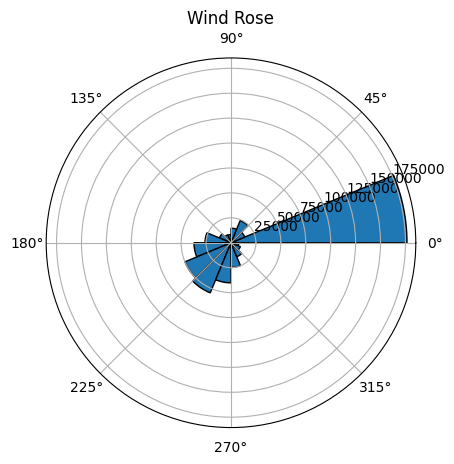

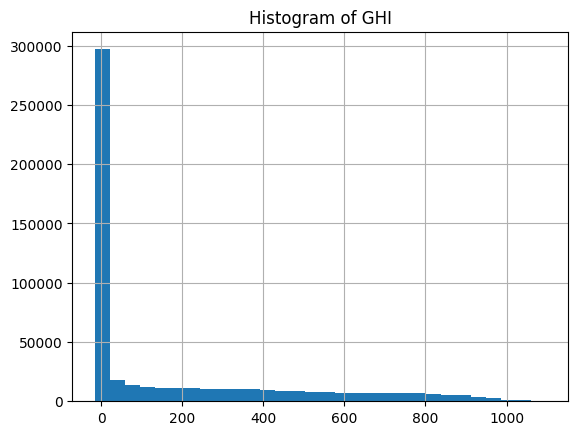

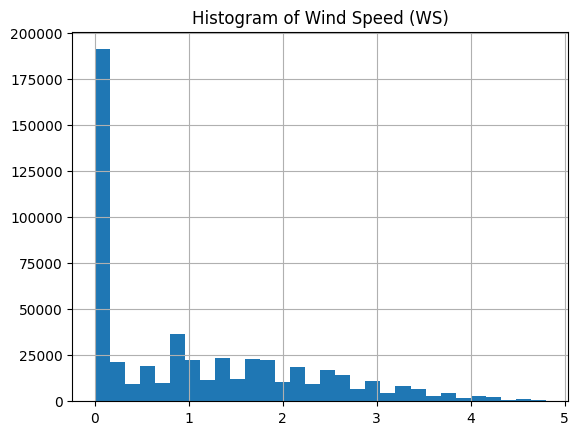

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# 5a. Wind rose (simple polar histogram)
ws = df_clean['WS']
wd = np.deg2rad(df_clean['WD'])
bins = 16
counts, dir_edges = np.histogram(wd, bins=bins)
width = (2*np.pi) / bins

ax = plt.subplot(projection='polar')
ax.bar(dir_edges[:-1], counts, width=width, edgecolor='k', align='edge')
ax.set_title("Wind Rose")
plt.show()

# 5b. Histograms for GHI and WS
plt.figure()
df_clean['GHI'].hist(bins=30)
plt.title("Histogram of GHI")
plt.show()

plt.figure()
df_clean['WS'].hist(bins=30)
plt.title("Histogram of Wind Speed (WS)")
plt.show()

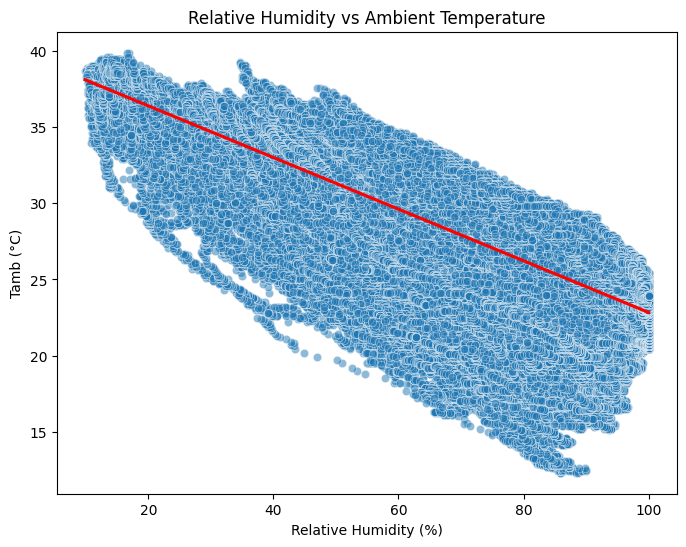

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clean, x='RH', y='Tamb', alpha=0.5)
sns.regplot(data=df_clean, x='RH', y='Tamb', scatter=False, color='red')
plt.title("Relative Humidity vs Ambient Temperature")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("Tamb (°C)")
plt.show()

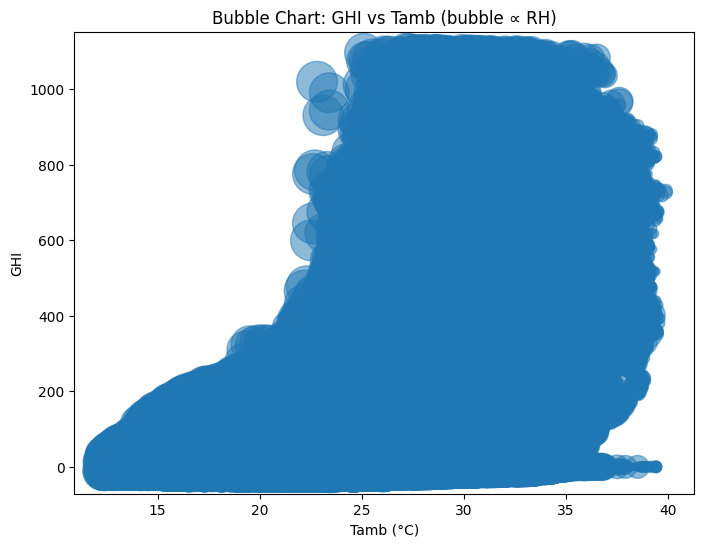

In [19]:
import matplotlib.pyplot as plt

# Scale bubble sizes from RH
sizes = (df_clean['RH'] - df_clean['RH'].min() + 1) * 10

plt.figure(figsize=(8,6))
plt.scatter(df_clean['Tamb'], df_clean['GHI'], s=sizes, alpha=0.5)
plt.title("Bubble Chart: GHI vs Tamb (bubble ∝ RH)")
plt.xlabel("Tamb (°C)")
plt.ylabel("GHI")
plt.show()